# 本次研讨课内容:
   问答摘要内容讲解:
    1. beam search 讲解.这一部分有很多现成的框架，不一定要自己去写
    2. seq2seq baseline 编写\训练\测试.
    3. 提交你的第一版成绩.
    4. 预测结果分析,模型提升改进点讨论

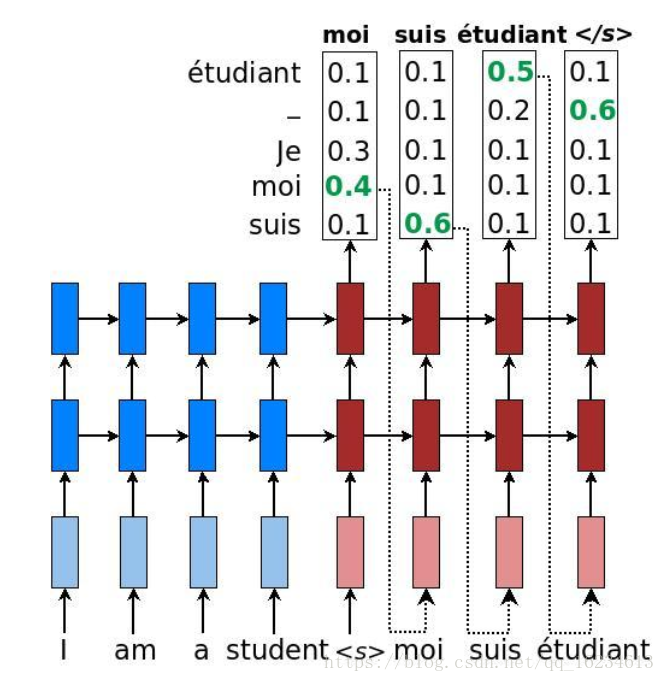  

解码是seq2seq模型的常见问题，常用方法有贪心搜索`（Greedy Search）`集束搜索`（Beam Search）`。

Decoder根据Encoder的中间语义编码向量c和`<s>`标签得到第一个输出的概率分布`[0.1,0.1,0.3,0.4,0.1]`，选择概率最大的`0.4`，即`moi`。

根据隐向量h1h1和moi得到第二个输出的概率分布`[0.1,0.1,0.1,0.1,0.6][0.1,0.1,0.1,0.1,0.6]`，选择概率最大的`0.6`，即`suis`。

以此类推，直到遇到`<\s>`标签，得到最终的序列`moi suis étudiant`.

解码是seq2seq模型的常见问题，常用方法有贪心搜索`（Greedy Search）`集束搜索`（Beam Search）`。

Decoder根据Encoder的中间语义编码向量c和`<s>`标签得到第一个输出的概率分布`[0.1,0.1,0.3,0.4,0.1]`，选择概率最大的`0.4`，即`moi`。

根据隐向量h1h1和moi得到第二个输出的概率分布`[0.1,0.1,0.1,0.1,0.6][0.1,0.1,0.1,0.1,0.6]`，选择概率最大的`0.6`，即`suis`。

以此类推，直到遇到`<\s>`标签，得到最终的序列`moi suis étudiant`.

# 集束搜索  Beam search

上面的贪心搜索只选择了概率最大的一个，而集束搜索则选择了概率最大的前k个。这个k值也叫做集束宽度（Beam Width）。

还是以上面的例子作为说明，k值等于2，则集束搜索的过程如下图：

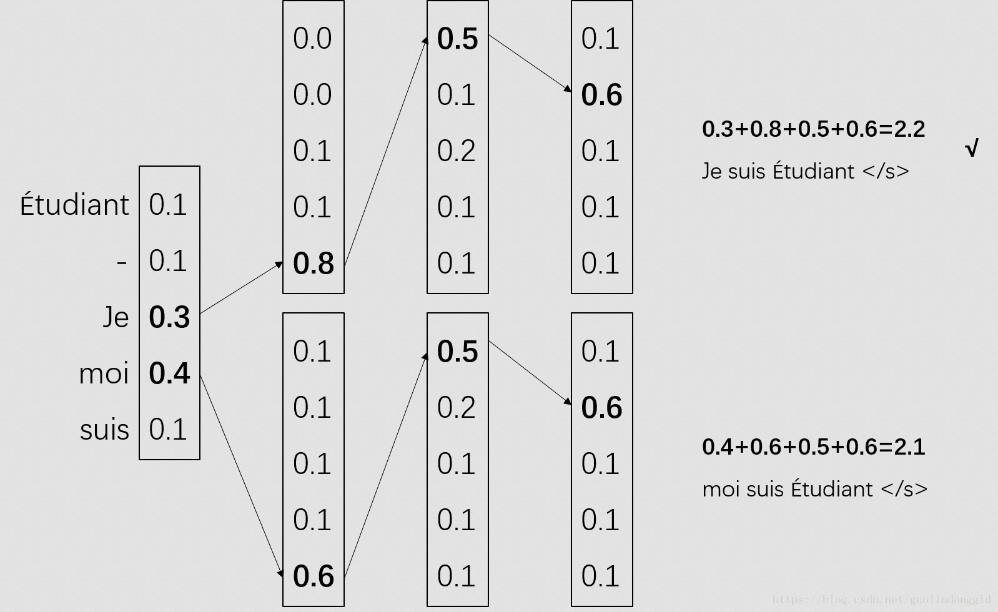

得到第一个输出的概率分布`[0.1,0.1,0.3,0.4,0.1] [0.1,0.1,0.3,0.4,0.1]`，选择概率最大的前两个，`0.3`和`0.4`，即`Je`和`moi`。

然后`Je`和`moi`分别作为`Decoder`的输入，得到两个概率分布，然后再选择概率和最大的前两个序列，`0.3+0.8`和`0.4+0.6`，即`Je suis`和`moi suis`。

以此类推，最终可以得到两个序列，即`Je suis étudiant`和`moi suis étudiant`，很明显前者的概率和最大，为`2.2`，所以这个序列是最终得到的结果。

集束搜索本质上也是贪心的思想，只不过它考虑了更多的候选搜索空间，因此可以得到更多的翻译结果。

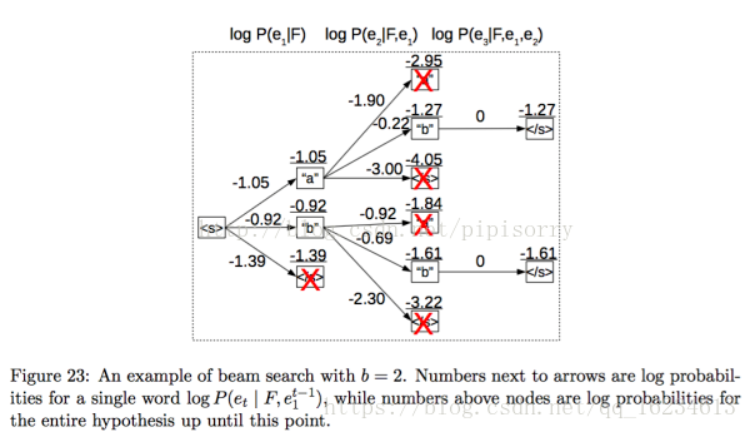
集束搜索可以认为是维特比算法的贪心形式，在维特比所有中由于利用动态规划导致当字典较大时效率低，而集束搜索使用beam size参数来限制在每一步保留下来的可能性词的数量。集束搜索是在测试阶段为了获得更好准确性而采取的一种策略，在训练阶段无需使用。

假设字典为[a,b,c]，beam size选择2，则如下图有：

1：在生成第1个词的时候，选择概率最大的2个词，那么当前序列就是a或b

2：生成第2个词的时候，我们将当前序列a或b，分别与字典中的所有词进行组合，得到新的6个序列aa ab ac ba bb bc,然后从其中选择2个概率最高的，作为当前序列，即ab或bb

3：不断重复这个过程，直到遇到结束符为止。最终输出2个概率最高的序列。

Beam 搜索要保存每一个时间步的一些中间结果，包括你的隐藏层和Attention的一些权重，所以你在搜索的时候，你不仅要把当前时间步的信息，还要把模型中间的一些结果也要保存下来，带在里边进行搜索

## beam search的使用

直接调用tf包：  
[seq2seq/BeamSearchDecoder](https://tensorflow.google.cn/addons/api_docs/python/tfa/seq2seq/BeamSearchDecoder?hl=en)  
也可以自己写

# 加载训练好的模型

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')  # 返回notebook的上一级目录
from utils.wv_loader import load_vocab
from utils.data_loader import load_dataset, build_dataset
from utils.config import *
import numpy as np
from utils.gpu_utils import config_gpu
config_gpu()
import tensorflow as tf
from seq2seq_tf2.seq2seq_model import Seq2Seq

D:\Learning\Project\QA\version1


Building prefix dict from the default dictionary ...
2020-05-20 14:31:52,134 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\17854\AppData\Local\Temp\jieba.cache
2020-05-20 14:31:52,135 : DEBUG : Loading model from cache C:\Users\17854\AppData\Local\Temp\jieba.cache
Loading model cost 0.626 seconds.
2020-05-20 14:31:52,761 : DEBUG : Loading model cost 0.626 seconds.
Prefix dict has been built successfully.
2020-05-20 14:31:52,763 : DEBUG : Prefix dict has been built successfully.


1 Physical GPUs, 1 Logical GPUs


In [3]:
vocab, reverse_vocab = load_vocab(vocab_path)
batch_size=3  # 这里暂时使用batch_size为3进行讲解
vocab_size=len(vocab)
# embedding_matrix = load_word2vec_file(save_wv_model_path)
params = {}
params["vocab_size"] = vocab_size
params["embed_size"] = 500
params["enc_units"] = 512
params["attn_units"] = 512
params["dec_units"] = 512
params["batch_size"] = 3
params["beam_size"]=3

params['min_dec_steps']=4
params['max_dec_steps']=50

In [4]:
len(vocab)

31820

In [5]:
# 建立数据集
# build_dataset(train_data_path, test_data_path)

In [6]:
train_X,train_Y,test_X = load_dataset()

In [7]:
train_X.shape

(82873, 200)

# 载入模型

In [8]:
params

{'vocab_size': 31820,
 'embed_size': 500,
 'enc_units': 512,
 'attn_units': 512,
 'dec_units': 512,
 'batch_size': 3,
 'beam_size': 3,
 'min_dec_steps': 4,
 'max_dec_steps': 50}

In [9]:
model = Seq2Seq(params)

In [10]:
model

# 2 读取训练好的模型

In [11]:
from utils.config import checkpoint_dir, checkpoint_prefix

In [12]:
ckpt = tf.train.Checkpoint(Seq2Seq=model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)
print("Model restored")

Model restored


# code 

要进行Beam搜索的话，每一层的中间状态我们要保存下来，这样的话最好就是我们先定义一个类，来存储我们每一个时间步的中间结果。这里边包含：
tokens: 每个（当前）时间步的输入
log_probs： 使用log算一下概率
hidden, attn_dists： 隐藏层和Attention的权重，这两个要保存下来才能进行下一步的操作

In [13]:
class Hypothesis:
    """ Class designed to hold hypothesises throughout the beamSearch decoding """
    def __init__(self, tokens, log_probs, hidden, attn_dists):
        self.tokens = tokens  # list of all the tokens from time 0 to the current time step t
        self.log_probs = log_probs  # list of the log probabilities of the tokens of the tokens
        self.hidden = hidden  # decoder hidden state after the last token decoding
        self.attn_dists = attn_dists  # attention dists of all the tokens
        self.abstract = ""

    def extend(self, token, log_prob, hidden, attn_dist):
        """
        Method to extend the current hypothesis by adding the next decoded token and 
        all the informations associated with it
        tokens：这里还定义了一个extend方法，在这里返回一个构造的新的对象，这里边就包括了它之前的Token和它新的
        Token，因为这里是一个序列，所以我们在构建一个新的Token，也就是下一个时间步的时候，我们要把上一
        个时间步的token给保存下来，然后保存一个序列的token
        
        log_probs：然后保存这一条路径下的所有概率
        hidden：这一条路径下的每一个时间步的隐藏层
        attn_dists：每一个时间步的Attention的权重
        """
        return Hypothesis(tokens=self.tokens + [token],  # we add the decoded token
                          log_probs=self.log_probs + [log_prob],  # we add the log prob of the decoded token
                          hidden=hidden,  # we update the state
                          attn_dists=self.attn_dists + [attn_dist])
    @property
    def latest_token(self):
        return self.tokens[-1]

    @property
    def tot_log_prob(self):
        return sum(self.log_probs)

    @property
    def avg_log_prob(self):
        return self.tot_log_prob / len(self.tokens)

# 初始化一个对象列表
拿到上边这个类之后，来构造每一步的输入和输出，这里就是基于之前的Encoder Decoder的代码，而这一部分的代码已经整合到seq2seq这个model里边了

In [14]:
batch_size

3

In [15]:
enc_inp=test_X[:3]  # 构造一个一个batch大小的输入

In [16]:
enc_inp.shape  # batch_size 的大小为32,200维的输入，即浅蓝色框下边的箭头，输入三个句子，输入到encoder里边去

(3, 200)

In [17]:
# 这里得到的两个输出，就代表了上边输入到encoder里边的一句话，也就是这个200维的序列得到的它里边包含的隐藏信息
enc_output, enc_hidden = model.call_encoder(enc_inp) 
# 得到这两个输出以后就可以在这里边解析出后边要翻译出的那句话
# encoder的内部执行机制：一次输入一个batch句话，每一句话长度等长，排列成一个二维的数组，
# 从第一列开始，每一个时间步是输入进去一列，比如这里有三句话，每次去处理这三句话的第一个词，一个词一个
# 词，一个时间步一个时间步的处理，比如说我们三句话，我们都先处理第一个词，第一个词都处理完了之后处理第
# 二个词，同时进行三句话的预测，所以我们在构建模型的时候我们要先告诉它一个batch_size是多少

In [18]:
enc_output.shape  # 这里的512就是单元数

TensorShape([3, 200, 512])

In [19]:
enc_output[1][2]

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([-9.01728153e-01,  2.18153186e-02, -6.60641789e-02,  3.20381881e-03,
        6.05229139e-01, -1.87322840e-01,  3.05371016e-01, -7.72027135e-01,
        6.48348243e-04,  6.21474981e-01,  7.82121718e-01,  9.61939454e-01,
       -6.93644047e-01,  4.17211682e-01,  9.39040124e-01, -6.89205453e-02,
       -6.33134782e-01, -8.71052325e-01, -4.58698384e-02, -1.47606060e-01,
        7.96244815e-02,  5.86795919e-02, -9.13170397e-01,  2.57810295e-01,
       -6.77256405e-01, -2.68429574e-02, -8.46569240e-02,  2.56712623e-02,
        2.12526438e-03,  2.85812113e-02, -1.94886640e-01,  1.39837014e-02,
        3.69913690e-02,  8.33385959e-02, -5.48355095e-03, -4.03038748e-02,
       -1.10710226e-02,  7.00570494e-02,  9.65748429e-02, -5.46728782e-02,
        4.32846874e-01, -1.12503149e-01,  2.06724554e-01, -2.80178208e-02,
       -5.45944013e-02, -1.52453840e-01,  4.93986718e-02,  1.64372455e-02,
        7.85755634e-01,  2.33888239e-01, -9.99198318

In [20]:
enc_hidden.shape  # 隐藏层单元数量就是512，一共输入了三个句子

TensorShape([3, 512])

In [21]:
# 先会构建一个这样的对象来存储Decoder里边进行beam搜索的时候需要的条件
hyps = [Hypothesis(tokens=[vocab['<START>']],  # 存Token
                   log_probs=[0.0],  # 存概率
                   hidden=enc_hidden[0],  # 隐藏层权重
                   attn_dists=[],  # Attention权重
                   ) for _ in range(params['batch_size'])]  # 初始化batch_size大小的个数个这样的对象

In [22]:
hyps  # 这个对象中包含着这3句话的起始位置，这里边的几个变量用来保存中间的条件


In [23]:
# vocab {a c f e p}

In [24]:
# token [c f p]

In [25]:
# <START> 

In [26]:
# hyps

In [27]:
# 构造一个list来存储我们每次遍历的结果
results = []  # list to hold the top beam_size hypothesises
# 统计遍历多少个时间步
steps = 0  # initial step

## 获取最新tokens 

In [28]:
# 通过这个对象，我们拿到第一次要传进去的token
latest_tokens = [h.latest_token for h in hyps]  

In [29]:
latest_tokens  # 这里传进去的token就是三个句子最前边的三个<start>,它们对应的索引值就是31816

[31816, 31816, 31816]

## 隐藏层状态

In [30]:
hiddens = [h.hidden for h in hyps]

In [31]:
hiddens  # 这里是一个list，里边放了三个隐藏层，可以想象为将这个模型复制了三份

[<tf.Tensor: shape=(512,), dtype=float32, numpy=
 array([ 4.75809157e-01, -3.01006168e-01, -7.21803248e-01,  6.12385804e-03,
        -4.23826844e-01,  7.57875443e-01,  1.49843901e-01, -1.53137565e-01,
        -1.00000000e+00, -4.12583888e-01,  5.07908821e-01,  9.99874890e-01,
         8.42135191e-01, -3.90840828e-01, -2.58858979e-01, -9.83026445e-01,
         8.51745725e-01, -1.00000000e+00, -2.05132023e-01, -2.87212282e-01,
         1.45248607e-01,  6.08152568e-01,  1.42682388e-01,  2.15699658e-01,
         9.99510646e-01, -5.70515811e-01,  7.73267746e-01,  3.09870522e-02,
         3.32268804e-01,  9.61264223e-02, -4.81538512e-02,  1.06133692e-01,
        -3.79273221e-02, -3.89973342e-01,  5.54882407e-01,  9.51780379e-01,
        -1.02702312e-01, -8.21358919e-01,  1.64468333e-01,  6.96813524e-01,
        -1.13946699e-01,  5.94363511e-01,  5.87670542e-02,  1.79725081e-01,
         1.70377240e-01,  3.20247948e-01, -9.93368983e-01,  1.86411783e-01,
        -9.20519888e-01,  5.75073063e-0

In [32]:
len(hiddens)  # 同样这里会得到三个隐藏层的状态

3

![](https://img-blog.csdn.net/20180414103300419)

## 单步运行decode

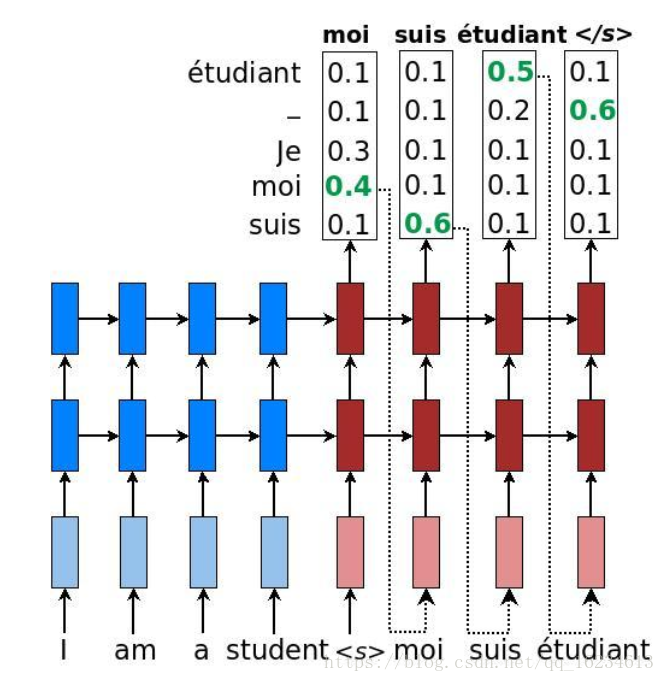

encoder的内部执行机制：一次输入一个batch句话，每一句话长度等长，排列成一个二维的数组，从第一列开始，每一个时间步是输入进去一列，比如这里有三句话，每次去处理这三句话的第一个词，一个词一个词，一个时间步一个时间步的处理，比如说我们三句话，我们都先处理第一个词，第一个词都处理完了之后处理第二个词，同时进行三句话的预测，所以我们在构建模型的时候我们要先告诉它一个batch_size是多少。

对于一次传入batch_size个句子，也就是每一个时间步处理batch_size个词，这个过程可以想象成将整个模型复制了batch_size 份，每一份都有一个隐藏层状态和encoder的输出，将这个输出各自放到一个list列表中

到这里，我们就拿到了深蓝色块往深红色块的箭头部分的数据，也就是encoder的输出：enc_output, enc_hidden,然后我们会调用红色的部分进行decode，调用红色的这一部分就要拿到蓝色的输入

由于前边的encoder里边已经将3个句子的encode已经都拿到了，我们这里进行一步一步的去拿到它decoder里边的东西

In [33]:
# 先将之前填充的字段的Index拿到
pad_index = vocab['<PAD>']
nuk_index = vocab['<UNK>']
start_index = vocab['<START>']
stop_index = vocab['<STOP>']

In [34]:
# 第一轮
steps=0

In [35]:
# 先构造一个单步decode的方法，先拿到蓝色部分的输出，decoder的输入，还有这里的dec_hidden ,第一次导入的
# dec_hidden的值就是enc_hidden 
def decoder_onestep(enc_output,dec_input,dec_hidden):
    """
    将参数传进来以后会调用一个decoder的方法，来解析出第一个词，这里传进去的输入就是enc_output，隐藏层
    状态和当前decoder 的输入，输入进来以后，调用model.call_decoder_onestep这个方法,这个方法就是将
    前边的几次课的内容穿了起来：先是会调用一个Attention，计算一下上下文的分数（context vector）和注
    意力权重，拿到之后再调用一下decoder，拿到它要预测出来的结果，和它要输到下一个时间步的隐藏层状态，最
    后将这四个结果返回出来。
    
    这里也就是说，在第一个深红色的块输入到第二个深红色块的箭头部分会得到返回的四个结果，包括它这个时间步
    的输出和它这个时间步输出的隐藏层状态，它这个时间步的上下文的权重和Attention的权重。这四部分拿到之后
    去计算一下它预测的概率。
    
    它预测的这个概率，如果是一句话的话，就是一个(1, vocab_size)的这样的序列。
    
    然后就开始beam搜索里边比较关键的一部分：先拿到top-k,比如说beam_size=3的话，就将(1, vocab_size)
    这个序列里边概率最高的三个拿出来（这个序列里边每一个索引对应着一个概率值），拿出来以后，在tensorflow
    里边有tf.nn.top_k()这个方法，通过这个方法可以得到它前k个大的概率，自己这些概率对应的index。
    
    拿到之后，将这单个概率去一个log，也不知道为啥这样做，后边会计算一个它的平均的概率
    
    最后把这一部分的中间结果全部返回出来，这就是一个时间步的东西
    
    假设对象序列可以这样理解：
    在sequence2sequence模型中，beam search的方法只用在测试的情况，因为在训练过程中，
    每一个decoder的输出是有正确答案的，也就不需要beam search去加大输出的准确率。

    测试的时候，假设词表大小为3，内容为a, b, c. beam size是2
    decoder解码的时候：

    1： 生成第1个词的时候，选择概率最大的2个词，假设为a,c,那么当前序列就是a,c

    2：生成第2个词的时候，我们将当前序列a和c，分别与词表中的所有词进行组合，得
    到新的6个序列: aa ab ac ca cb cc,然后从其中选择2个得分最高的，作为当前
    序列，假如为: aa cb

    3：后面会不断重复这个过程，直到遇到结束符为止。最终输出2个得分最高的序列。
    这里的序列是会一直保存着的，到最后边之所以选择两个得分最高的序列是因为，这里
    的出来的分也是在不断的累加的。

    """
    
    # 单个时间步 运行
    preds, dec_hidden, context_vector,attention_weights = model.call_decoder_onestep(dec_input,dec_hidden, enc_output)
    # 拿到top k个index 和 概率
    top_k_probs, top_k_ids = tf.nn.top_k(tf.squeeze(preds), k=params["beam_size"])
    # 计算log概率
    top_k_log_probs = tf.math.log(top_k_probs)
    # 返回需要保存的中间结果和概率
    return preds,dec_hidden,context_vector,attention_weights,top_k_log_probs,top_k_ids

这里构造了上边的这个方法之后，我们来一步一步的进行搜索

## 单次搜索

In [45]:
# 首先调用一下encoder的这个方法
# 计算得到encoder的输出
enc_output, enc_hidden = model.call_encoder(enc_inp)
print(enc_output.shape)
print(enc_hidden.shape)

(3, 200, 512)
(3, 512)


In [37]:
# 第一个decoder输入 开始标签，也就是全部都是<start>,在这里也就是3个<start>
# latest_tokens: 这个参数，最新的token指的就是前边构造的对象hyps，保存中间结果的对象，
# 里边拿到它最顶上的token就是最新的token，第一步的时候，最顶上的token就是<start>,拿到这个token之后
# 用这个token作为decoder的输入，那么输入就是一个batch的<start>对应的索引
dec_input = tf.expand_dims(latest_tokens, 1)

In [38]:
dec_input

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[31816],
       [31816],
       [31816]])>

In [39]:
# 第一个隐藏层输入  就是将encoder的隐藏层状态穿给decoder层
dec_hidden = enc_hidden

In [40]:
# 单步运行  调用上边的decoder的方法，单步执行decoder，这里的单步指的是：一次执行一列红色的
# 执行完这个操作之后就能拿到要预测的结果
preds, dec_hidden, context_vector,attention_weights, top_k_log_probs, top_k_ids = decoder_onestep(enc_output,dec_input,dec_hidden)
#这里相当于是拿到了所有的中间结果

Encoder-Decoder输入机制：
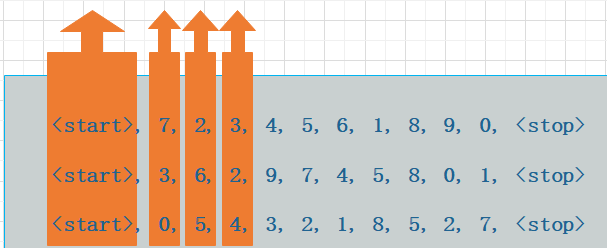

In [41]:
preds.shape
# 这里是单步运行，所以一次就放进去三个句子中同一索引位置的三个词（也就是一列）
# 因为同时输入三个句子的第n个词，所以就有对应着三个词预测结果，就相当于将模型复制了3份，每份预测一个词
# 的时候就会得出词表中所有词的一个概率,每个词预测都会得到31820(词表的大小)个概率值


TensorShape([3, 31820])

In [42]:
# 上边拿到了所有的中间结果，这里来遍历一下所有的中间结果
# 现阶段全部可能情况，定义一个空的list来存储
all_hyps = []
# 原有的可能情况数量，上一个时间步的情况有多少个
# hyps 这个对象中包含着这3句话的起始位置，这里边的几个变量用来保存中间的条件
num_orig_hyps = 1 if steps == 0 else len(hyps)
# 这里判断一下是不是第一个，要是第一个的话就没有前边的状态和结果了

# 遍历添加所有可能结果
# 这里是根据总共进行了多少步的预测，利用for循环，把每一步得到的中间结果都解析出来
for i in range(num_orig_hyps):
    h, new_hidden, attn_dist = hyps[i], dec_hidden[i], attention_weights[i]
    # 分裂 添加 beam size 种可能性
    for j in range(params['beam_size']):
        # 这里的beam search有一个宽度，就根据这个宽度来搜，比如说宽度是3，就会拿到三个不同的下一步的情况
        # 这里就是拿到这个词预测得到的三个最大概率，再分别进行预测的过程，再得到三个最大的概率
        # 构造可能的情况
        new_hyp = h.extend(token = top_k_ids[i, j].numpy(),
                                       log_prob = top_k_log_probs[i, j],
                                       hidden = new_hidden,
                                       attn_dist = attn_dist)
        # 添加可能情况
        all_hyps.append(new_hyp)

上边构建一个这样的对象来存储Decoder里边进行预测搜索的时候需要的条件    
hypothesis：假设  
```
hyps = [Hypothesis(tokens=[vocab['<START>']],
                   log_probs=[0.0],
                   hidden=enc_hidden[0],
                   attn_dists=[],
                   ) for _ in range(params['batch_size'])]
```
假设这样的一个情况：  
有一个词表(vocab)：{a, b, f, e, c}  
第一次预测，得到5个词的概率，beam search的宽度为3，于是从这5个词的预测结果里边选择3个概率最大的  
得到三个概率最大的词（token）：{b, f, c}，相当于下一个时间步我要预测这三个词，因为要同时预测三个词
所以当前的一个节点就要裂变成3个节点，因为每一次调用decoder就只传一个词进去，这里就相当于复制三个模型同时预测，所以这里通过hyps这个对象来保存它这个时间步的信息(词本身的信息，概率信息，隐藏层信息，Attention信息)，保存结束后再对这三个词都做一次decoder,得到三组概率值，每组取三个最大概率，将这得到的九个最大概率值放在一起，在从这里边取三个最大的概率进行下一步的预测.

In [ ]:
token b, f, c 

In [ ]:
# 这里就表示输入3个<start>之后，得到的预测结果概率最大的前三个词为b  f  c，将这些组合进一步进行预测
# 得到三组相同大小（vocab_size）的概率值
1. <start> b  
2. <start> f
3. <start> c

# 再下一步的时候，每一种会再出现三种情况，将它们合在一起，从这9种里边再选择top3，再依次循环进行

In [139]:
all_hyps

## 排序

In [140]:
# 重置  这里的假设集中每次只放3个值，每次预测结束之后都要清空重置
hyps = []

In [142]:
# 对新预测得到的三组概率值
# 按照概率来排序，再选取top-k个句子出来 ，这里是一个对象的列表，对它的key可以使用一个lambda来做，h表示这个对象，拿出对象中的平均概率进行一个排序
sorted_hyps = sorted(all_hyps, key=lambda h: h.avg_log_prob, reverse=True)

# 这里之所以要做平均是因为
# 对于a: 0.7  b: 0.5  c: 0.2       和        a: 0.1  b: 0.2  c: 0.1  d: 0.2  e: 0.1 
# 如果只是根据整个句子的总的概率来算的话，后边的句子的概率还小于前边的句子，所以最好用平均


In [66]:
# 筛选top前beam_size句话 top 3  选择top3的过程
# 这里的hyps(h)就相当于一个栈，每次预测结束之后将预测完的词(token)放进去
for h in sorted_hyps:
    if h.latest_token == stop_index:  
        # 进行一个简单的判断，看看是否遇到了结尾符，遇到之后就不需要再进行预测了
        # 长度符合预期,遇到句尾,添加到结果集那个list里边，把这个对象放进去就可以了，因为每个对象里边保存了每个时间步的值，概率，注意力权重...全都保存了
        if steps >= params['min_dec_steps']:
            results.append(h)
    else:
        # 未到结束 ,添加到假设集,将中间结果信息保存好，继续继续下一步预测
        hyps.append(h)
    
    # 如果假设句子正好等于beam_size 或者结果集正好等于beam_size 就不在添加
    # 就像带红色叉的图一样，很多的句子走着走着就遇到结束符了，句子数量就减少，就会存在等于beam_size的情况
    if len(hyps) == params['beam_size'] or len(results) == params['beam_size']:
        break
steps += 1

In [67]:
# 上边的步骤都是单步执行，将它们套在一个大的for循环里边，当所有的都遍历完了之后
# 就是每一个时间步都遍历完了之后，我们会去判断一下这个结果集是否为0，如果为0，就把假设的结果放进去
# 如果没有遇到stop，就把当前step预测的结果给它就可以了
if len(results) == 0:
    results = hyps

这里为什么用平均的log计算呢？(avg_log_prob)
它每一个词都会有一个概率，平均的概率就是每个词的概率的累加除以词的个数

In [144]:
# 计算最终的结果的时候也是使用排序来计算，拿到平均概率最高的句子
hyps_sorted = sorted(results, key=lambda h: h.avg_log_prob, reverse=True)

In [145]:
best_hyp = hyps_sorted[0]

In [147]:
# 拿到平均概率最高的句子里边的token
best_hyp.abstract = " ".join([reverse_vocab[index] for index in best_hyp.tokens])

In [148]:
best_hyp.abstract  # 因为这个模型没有训练，所以拿到的就只有一个词

'<START> 捡'

References

[1] https://www.tensorflow.org/tutorials/seq2seq

[2] https://blog.csdn.net/guolindonggld/article/details/79938567

# beam search 方法整合
没有写完，只是将前边的步骤串了起来

In [79]:
def beam_decode(model,batch,vocab, params):
    # 输入是模型，batch数据，vocab，一些初始化参数
    # 初始化mask
    start_index = vocab['<START>']
    stop_index = vocab['<STOP>']
    
    batch_size= params['batch_size']
    
    # 一个方法里边套一个方法，里边的方法就可以拿到外边的方法定义的变量
    # 单步decoder
    def decoder_onestep(enc_output,dec_input,dec_hidden):
        # 单个时间步 运行
        preds, dec_hidden, context_vector,attention_weights = model.call_decoder_onestep(dec_input,dec_hidden, enc_output)
        # 拿到top k个index 和 概率
        top_k_probs, top_k_ids = tf.nn.top_k(tf.squeeze(preds), k=params["beam_size"])
        # 计算log概率
        top_k_log_probs = - tf.math.log(top_k_probs)
        # 返回需要保存的中间结果和概率
        return preds,dec_hidden,context_vector,attention_weights,top_k_log_probs,top_k_ids
    
    # 计算第encoder的输出
    enc_output, enc_hidden = model.call_encoder(batch)
    
    # 初始化batch size个 假设对象  初始化每个时间步的对象，用来保存每次预测得到的三个最大概率的词的信息
    # 以及词的概率，及相关的隐藏层，Attention信息
    hyps = [Hypothesis(tokens=[start_index],
                   log_probs=[0.0],
                   hidden=enc_hidden[0],
                   attn_dists=[],
                   ) for _ in range(batch_size)]
    # 初始化结果集  定义一个最终的结果集
    results = []  # list to hold the top beam_size hypothesises
    # 遍历步数  定义遍历的时间步
    steps = 0  # initial step
    
    # 第一个隐藏层输入  输入<start>的时间步的隐藏层输入为encoder层的隐藏层的输出
    dec_hidden = enc_hidden
    
    
    # 长度还不够 并且 结果还不够 继续搜索
    # 设置终止条件  要不就是时间步超过了自己定义的最大步长，比如说要预测的结果平均长度是40，这里
    # 就定义为40，所以要是超过了并且我们的结果中已经有三条已经结束了的结果就结束了
    while steps < params['max_dec_steps'] and len(results) < params['beam_size']:
        # 接下来就是一个时间步一个时间步的去拿最优的结果
        # 第一个时间步我们那的是上边初始化的对象里边的第一个token，这里就是<start>
        # 获取最新待使用的token
        latest_tokens = [h.latest_token for h in hyps]
        # 获取所以隐藏层状态 
        # 接下来这一部分的内容就是既要保存它的中间结果，又要调用我们的模型来预测出下一步
        # 从初始化对象中拿到存储的隐藏层信息，也就是encoder的隐藏层的输出状态，
        # 来作为第一个decoder的隐藏层的输入
        hiddens = [h.hidden for h in hyps]
        # 最新输入  构建一个<start>的tensor来作为我们第一个时间步的输入
        dec_input = tf.expand_dims(latest_tokens, 1)
        
        # 单步运行decoder 计算需要的值  拿到第一个时间步计算完的结果
        preds, dec_hidden, context_vector,attention_weights, top_k_log_probs, top_k_ids = decoder_onestep(enc_output,dec_input,dec_hidden)
        
        # 现阶段全部可能情况
        # 遍历每一个时间步保存的结果，并且保存当前时间步得到结果
        all_hyps = []
        # 原有的可能情况数量
        num_orig_hyps = 1 if steps == 0 else len(hyps)
        # 第一次进行预测的时候，即输入<start>进行预测的时候，step=0，所以num_orig_hyps = 1

        # 遍历添加所有可能结果
        # 这里就是根据现在假设的对象里边存的三个词的信息，进行新的预测，得到三个概率最高的词以后
        # 存到
        for i in range(num_orig_hyps):  
            # 第一个时间步的时候这里只循环一次
            h, new_hidden, attn_dist = hyps[i], dec_hidden[i], attention_weights[i]
            # 分裂 添加 beam size 种可能性
            # 第一个时间步只循环一次，而这里的beam_size=3,所以这里的到的可能性只有 3种
            for j in range(params['beam_size']):
                # 在第一个时间步的预测的结果中选择三个概率值最高的结果（没有排序的过程怎么得到的？）
                
                
                # 这里beam_size=3的话就要代表一个对象就要跑三次，每个对象中存的三个词，每个词预测一次
                # 得到三个词的预测结果，总共选出九个概率值，组合在一起，选出最高的三个，存到新的假设对象
                # 中，用于下一个词的概率预测，并且把这个对象加入到下一要预测的list里边
                if params['batch_size']==1:
                    # 构造可能的情况
                    # 一次只传进来一个句子，batch_size=1
                    new_hyp = h.extend(token = top_k_ids[j].numpy(),
                                       log_prob = top_k_log_probs[j],
                                       hidden = new_hidden,
                                       attn_dist = attn_dist)
                else:
                    # 构造可能的情况
                    new_hyp = h.extend(token = top_k_ids[i, j].numpy(),
                                       log_prob = top_k_log_probs[i, j],
                                       hidden = new_hidden,
                                       attn_dist = attn_dist)
                # 添加可能情况
                # 这里的意思就是假设第一次预测得到三个概率最高的词，每一个又分别进行预测，
                # 得到了三组三个最大概率，总共九个，全部存起来，在下边进行排序，求出最高的三个，用于下边的预测
                all_hyps.append(new_hyp)
        
        # 重置
        hyps = []
        # 按照概率来排序  对这九个概率值进行排序
        sorted_hyps = sorted(all_hyps, key=lambda h: h.avg_log_prob, reverse=True)
        
        # 筛选top前beam_size句话  对sorted_hyps里边排好序的9句话进行筛选
        for h in sorted_hyps:
            if h.latest_token == stop_index:
                # 长度符合预期,遇到句尾,添加到结果集
                if steps >= params['min_dec_steps']:
                    # 小于设置的最小句子就停止，这样的句子就不合法，就不要了，就停止
                    results.append(h)
            else:
                # 未到结束 ,添加到假设集  加到这里边是用于下一个时间步的预测
                hyps.append(h)
                
            # 在这里进行选择三个最靠前的排序，到三个了就退出for循环
            # 如果假设句子正好等于beam_size 或者结果集正好等于beam_size（？） 就不再添加
            if len(hyps) == params['beam_size'] or len(results) == params['beam_size']:
                break

        steps += 1  # 处理一句话就需要这个单元格这么长的代码来处理
        # 这里只是是实现了一次只预测一句话，还需要改进一下，实现一个batch一个batch的预测
        
    if len(results) == 0:
        results = hyps
    # 拿到结果之后取概率最大的那个输出
    hyps_sorted = sorted(results, key=lambda h: h.avg_log_prob, reverse=True)
    best_hyp = hyps_sorted[0]
    best_hyp.abstract = " ".join([reverse_vocab[index] for index in best_hyp.tokens])
    return best_hyp

我知道这里为什么是去最大概率的作为输出了：
实际的预测运行的机制是这样的：
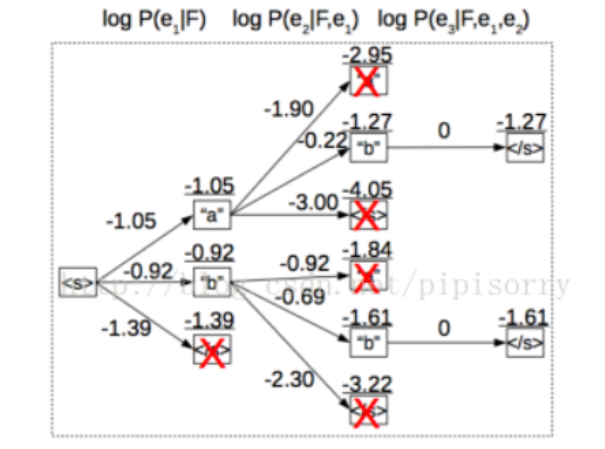
这里的过程就可以理解为概率累加的过程，第一次预测的到的最大的三个概率，会和它们得到的新的概率进行累加，得到总的概率，在总的概率的基础上再选择三个最高的概率，然后再预测，再依次累加....  


或许也可以直接理解为：每预测一个词的时候得到三个最大的概率值，选择概率值最大的值作为本次预测的输出，进行下一个词的预测的时候将这概率最高的三个词信息传到下一个词的中，即分别在这三个的基础上进行预测，得到三组预测结果，从这三组预测结果里边各选三个概率最高的值，放在一起进行选择，再从这个集合中选择三个概率最高的词传到下一个词的预测中去，依次进行，知道预测结束。

由这里的图可以看出，每一步的预测得到的概率都是一个累加的过程，一定有一条相加的路径实现了每一步中得到的最大概率相加，最后进行总的排序选择的时候，依旧选择概率值最大的句子，就能得到概率最高的预测的句子。
通过上边和下边这两个图可以看出

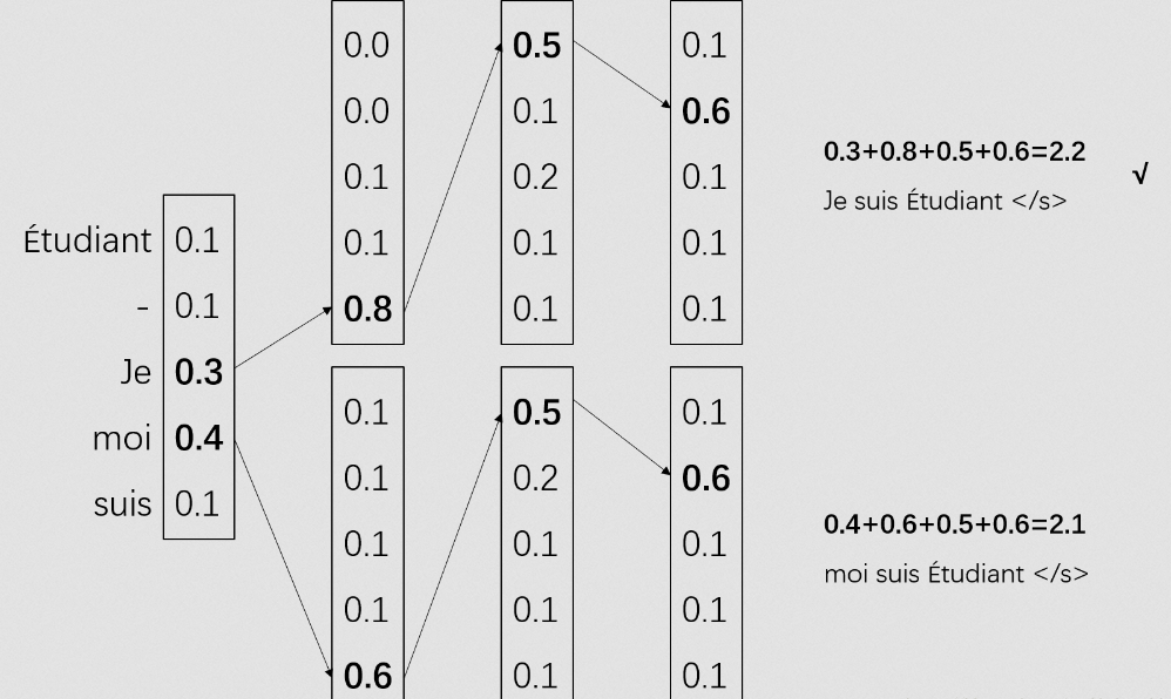

In [81]:
# 读取模型
model = Seq2Seq(params)

In [82]:
# 构造数据
test_batch=test_X[:batch_size]

In [83]:
test_batch.shape

(3, 200)

In [84]:
# 获得最好的语句
best_hyp=beam_decode(model,test_batch,vocab, params)

In [85]:
best_hyp.abstract

'<START> 左高右 难关 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段 齿合器 某一 第一段'